In [33]:
%load_ext autoreload
%autoreload 2
import numpy as np
import random
import json
import torch
from convexlocalisometry.vendor import HParams
from convexlocalisometry.atomic_geometry import get_atoms3_full, get_atoms4_full, get_atoms_4
import itertools

print('Loading ethanol data')

config_path = "/Users/samsonkoelle/montlake/experiments/configs/ethanol_full.json"
raw_data = "/Users/samsonkoelle/thesis_data/raw_data/ethanol.mat"

positions = np.load('/Users/samsonkoelle/positions.npy')
randomindices = np.load('/Users/samsonkoelle/indices.npy')

np.random.seed(1234)
random.seed(1234)

config = {}

with open(config_path) as f:
    config.update(json.load(f))

hparams = HParams(**config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading ethanol data


In [34]:
d = hparams.d
n_components = hparams.n_components
atoms2_feat = hparams.atoms2_feat
atoms3_feat = hparams.atoms3_feat
atoms4_feat = hparams.atoms4_feat
atoms2_dict = hparams.atoms2_dict
atoms3_dict = hparams.atoms3_dict
atoms4_dict = hparams.atoms4_dict
diagram = hparams.diagram

ii = np.asarray(hparams.ii)
jj = np.asarray(hparams.jj)
#load geometric features
natoms = positions.shape[1]
n = positions.shape[0]
atoms2 = np.asarray(list(itertools.combinations(range(natoms), 2)))
atoms2full = atoms2
atoms3 = np.asarray(list(itertools.combinations(range(natoms), 3)))
atoms4 = np.asarray(list(itertools.combinations(range(natoms), 4)))
atoms3full = get_atoms3_full(atoms3)
atoms4full = get_atoms4_full(atoms4)

if atoms2_feat:
    atoms2_feats = atoms2full
else:
    atoms2_feats = np.asarray([])

if atoms3_feat:
    atoms3_feats = atoms3full
else:
    atoms3_feats = np.asarray([])

if atoms4_feat:
    atoms4_feats = atoms4full
else:
    atoms4_feats = np.asarray([])

In [35]:
data = np.load('/Users/samsonkoelle/ethanolanglesfull_0524.npy')
n_neighbors = hparams.n_neighbors
atoms4_dicts= get_atoms_4(natoms, ii, jj)[0]
if atoms2_dict:
    atoms2_dicts = atoms2full
else:
    atoms2_dicts = np.asarray([])
if atoms3_dict:
    atoms3_dicts = atoms3full
else:
    atoms3_dicts = np.asarray([])


In [36]:
from scipy import sparse
from convexlocalisometry.transformation import exponential_transformation
from convexlocalisometry.manifold import local_pca
from convexlocalisometry.atomic_geometry import get_D_feats_feats

nsel = 100
dimension = 2
p = atoms4full.shape[0]

selected_points = np.random.choice(range(50000),nsel)
dg_x = np.asarray([get_D_feats_feats(positions[selected_points[i]],
           atoms2in = atoms2_feats,
           atoms3in = atoms3_feats,
           atoms4in = atoms4_feats,
           atoms2out = atoms2_dicts,
           atoms3out = atoms3_dicts,
           atoms4out = atoms4full) for i in range(nsel)])                           

power = 1


In [37]:
dg_M = np.zeros((nsel, dimension, p))
for i, sp in enumerate(selected_points):
    tangent_bases = local_pca(data, sp, n_neighbors, dimension)
    # NOTE (Sam): normalization prior to projection once again in the manifold case.
    dg_x_normalized = exponential_transformation(dg_x[i], power)
    dg_M[i] = np.einsum('b p, b d -> d p', dg_x_normalized, tangent_bases)

In [45]:
from convexlocalisometry.algorithm import greedy, group_basis_pursuit, brute
from convexlocalisometry.loss import isometry_loss
from tqdm import tqdm

In [53]:
losses = []
two_stage_losses = []
random_two_stage_losses= []
for i in tqdm(range(100)):
    X = dg_M[i]
    output = greedy(X, isometry_loss, dimension, []) # plainly brute is too hard 178**13 combinations
    loss = isometry_loss(X[:,output])
    losses.append(loss)
    data_transformed = exponential_transformation(X)
    beta = group_basis_pursuit(data_transformed)
    basis_pursuit_indices = np.where(np.linalg.norm(beta, axis = 1))[0]
    two_stage_output = basis_pursuit_indices[np.asarray(brute(X[:,basis_pursuit_indices], isometry_loss, dimension))] # plainly this is too hard 178**13 combinations
    two_stage_loss = isometry_loss(X[:,two_stage_output])
    two_stage_losses.append(two_stage_loss)
    random_indices = np.random.choice(range(X.shape[1]), len(basis_pursuit_indices), replace=False)
    random_two_stage_losses.append(isometry_loss(X[:,random_indices]))

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6754.11it/s]
  1%|▍                                          | 1/100 [00:08<14:30,  8.79s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 3772.99it/s]
  2%|▊                                          | 2/100 [00:18<15:22,  9.42s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4452.55it/s]
  3%|█▎                                         | 3/100 [00:27<14:53,  9.21s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4097.33it/s]
  4%|█▋                                         | 4/100 [00:37<15:01,  9.39s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12433.71it/s]
  5%|██▏                                        | 5/100 [00:46<14:38,  9.25s/it]

Computing brute force solution for dictionary dimension 389 and target_dimension 2



0it [00:00, ?it/s]
3346it [00:00, 33450.30it/s]
6692it [00:00, 32954.94it/s]
10194it [00:00, 33885.80it/s]
13704it [00:00, 34359.73it/s]
17141it [00:00, 33487.22it/s]
20494it [00:00, 33399.13it/s]
23953it [00:00, 33780.10it/s]
27441it [00:00, 34124.16it/s]
30910it [00:00, 34299.59it/s]
34342it [00:01, 33800.74it/s]
37725it [00:01, 33338.78it/s]
41268it [00:01, 33961.51it/s]
44668it [00:01, 33466.66it/s]
48134it [00:01, 33817.23it/s]
51533it [00:01, 33867.27it/s]
54922it [00:01, 33039.35it/s]
58232it [00:01, 31811.05it/s]
61425it [00:01, 31578.04it/s]
64590it [00:01, 31244.02it/s]
67793it [00:02, 31470.50it/s]
71149it [00:02, 32080.79it/s]
75466it [00:02, 32925.72it/s]
  6%|██▌                                        | 6/100 [00:57<15:35,  9.95s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6563.86it/s]
  7%|███                                        | 7/100 [01:06<14:48,  9.55s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11459.85it/s]
  8%|███▍                                       | 8/100 [01:14<14:05,  9.19s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7791.28it/s]
  9%|███▊                                       | 9/100 [01:23<13:54,  9.18s/it]

Computing brute force solution for dictionary dimension 444 and target_dimension 2



0it [00:00, ?it/s]
3093it [00:00, 30922.21it/s]
6482it [00:00, 32662.22it/s]
9835it [00:00, 33051.15it/s]
13141it [00:00, 32297.77it/s]
16374it [00:00, 31673.96it/s]
19861it [00:00, 32734.20it/s]
23139it [00:00, 30551.81it/s]
26457it [00:00, 31340.17it/s]
29615it [00:00, 30592.25it/s]
32936it [00:01, 31362.65it/s]
36088it [00:01, 31245.36it/s]
39303it [00:01, 31510.35it/s]
42463it [00:01, 30392.92it/s]
45791it [00:01, 31229.34it/s]
48926it [00:01, 30021.35it/s]
51945it [00:01, 23041.41it/s]
54496it [00:01, 19030.97it/s]
57249it [00:02, 20862.60it/s]
60048it [00:02, 22539.83it/s]
62884it [00:02, 24004.45it/s]
65526it [00:02, 24641.00it/s]
68657it [00:02, 26469.26it/s]
71627it [00:02, 27359.50it/s]
74506it [00:02, 27768.52it/s]
77575it [00:02, 28616.34it/s]
80993it [00:02, 30246.25it/s]
84421it [00:02, 31436.30it/s]
87771it [00:03, 32046.98it/s]
91341it [00:03, 33133.67it/s]
94688it [00:03, 33233.62it/s]
98346it [00:03, 29018.46it/s]
 10%|████▏                                     | 10/1

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11325.75it/s]
 11%|████▌                                     | 11/100 [01:47<15:27, 10.42s/it]

Computing brute force solution for dictionary dimension 267 and target_dimension 2



0it [00:00, ?it/s]
2250it [00:00, 22495.52it/s]
5138it [00:00, 26245.39it/s]
8479it [00:00, 29514.12it/s]
12046it [00:00, 31941.78it/s]
15579it [00:00, 33160.31it/s]
18896it [00:00, 33068.28it/s]
22279it [00:00, 33313.85it/s]
25611it [00:00, 33082.98it/s]
28994it [00:00, 33314.50it/s]
35511it [00:01, 31313.05it/s]
 12%|█████                                     | 12/100 [01:57<15:18, 10.43s/it]

Computing brute force solution for dictionary dimension 441 and target_dimension 2



0it [00:00, ?it/s]
1780it [00:00, 17792.89it/s]
4836it [00:00, 25299.78it/s]
7994it [00:00, 28165.93it/s]
11303it [00:00, 30107.81it/s]
14364it [00:00, 30286.06it/s]
17393it [00:00, 29801.73it/s]
20375it [00:00, 29529.10it/s]
23610it [00:00, 30410.98it/s]
26799it [00:00, 30867.37it/s]
30335it [00:01, 32244.30it/s]
33681it [00:01, 32612.17it/s]
36944it [00:01, 30973.10it/s]
40060it [00:01, 30933.71it/s]
43166it [00:01, 30701.41it/s]
46317it [00:01, 30937.26it/s]
49418it [00:01, 29932.20it/s]
52422it [00:01, 29499.01it/s]
55379it [00:01, 28899.69it/s]
58275it [00:01, 28635.22it/s]
61143it [00:02, 26722.47it/s]
64030it [00:02, 27318.22it/s]
66783it [00:02, 27298.79it/s]
69528it [00:02, 27279.14it/s]
72427it [00:02, 27775.48it/s]
75253it [00:02, 27916.54it/s]
78051it [00:02, 27923.82it/s]
80930it [00:02, 28179.71it/s]
83799it [00:02, 28329.99it/s]
86677it [00:02, 28462.68it/s]
89774it [00:03, 29209.41it/s]
92697it [00:03, 28161.70it/s]
97020it [00:03, 29024.96it/s]
 13%|█████▍            

Computing brute force solution for dictionary dimension 480 and target_dimension 2



0it [00:00, ?it/s]
3253it [00:00, 32520.57it/s]
6506it [00:00, 27193.50it/s]
9536it [00:00, 28473.08it/s]
12427it [00:00, 28293.45it/s]
15428it [00:00, 28880.89it/s]
18348it [00:00, 28983.25it/s]
21466it [00:00, 29683.34it/s]
24703it [00:00, 30523.58it/s]
27764it [00:00, 30459.76it/s]
30975it [00:01, 30961.56it/s]
34408it [00:01, 31985.53it/s]
37731it [00:01, 32361.52it/s]
40970it [00:01, 31846.02it/s]
44159it [00:01, 31094.94it/s]
47275it [00:01, 30064.25it/s]
50291it [00:01, 26956.89it/s]
53147it [00:01, 27388.69it/s]
55933it [00:01, 25727.50it/s]
58551it [00:02, 25423.52it/s]
61516it [00:02, 26585.18it/s]
64405it [00:02, 27234.32it/s]
67424it [00:02, 28082.02it/s]
70344it [00:02, 28404.82it/s]
73489it [00:02, 29292.05it/s]
76432it [00:02, 24891.91it/s]
79413it [00:02, 26187.72it/s]
82545it [00:02, 27590.67it/s]
85758it [00:02, 28865.09it/s]
88824it [00:03, 29378.53it/s]
91985it [00:03, 30024.28it/s]
95135it [00:03, 30455.71it/s]
98272it [00:03, 30723.97it/s]
101364it [00:03, 30082.

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 3851.52it/s]
 15%|██████▎                                   | 15/100 [02:32<15:24, 10.88s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14496.44it/s]
 16%|██████▋                                   | 16/100 [02:41<14:23, 10.28s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7427.93it/s]
 17%|███████▏                                  | 17/100 [02:51<13:57, 10.09s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6075.77it/s]
 18%|███████▌                                  | 18/100 [03:00<13:36,  9.96s/it]

Computing brute force solution for dictionary dimension 426 and target_dimension 2



0it [00:00, ?it/s]
3650it [00:00, 36498.82it/s]
7300it [00:00, 35856.22it/s]
10936it [00:00, 36083.08it/s]
14545it [00:00, 35982.14it/s]
18237it [00:00, 36315.32it/s]
21927it [00:00, 36512.49it/s]
25579it [00:00, 36417.33it/s]
29221it [00:00, 35647.73it/s]
32790it [00:00, 35513.63it/s]
36344it [00:01, 35431.75it/s]
39889it [00:01, 34819.43it/s]
43415it [00:01, 34950.42it/s]
46952it [00:01, 35074.66it/s]
50523it [00:01, 35263.55it/s]
54097it [00:01, 35404.87it/s]
57639it [00:01, 33946.60it/s]
61123it [00:01, 34203.74it/s]
64651it [00:01, 34516.62it/s]
68308it [00:01, 35122.09it/s]
72041it [00:02, 35775.46it/s]
75667it [00:02, 35918.20it/s]
79301it [00:02, 36042.35it/s]
82908it [00:02, 35802.05it/s]
86491it [00:02, 35758.09it/s]
90525it [00:02, 35457.19it/s]
 19%|███████▉                                  | 19/100 [03:11<13:53, 10.28s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12507.86it/s]
 20%|████████▍                                 | 20/100 [03:20<12:58,  9.74s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7729.06it/s]
 21%|████████▊                                 | 21/100 [03:28<12:17,  9.34s/it]

Computing brute force solution for dictionary dimension 146 and target_dimension 2



0it [00:00, ?it/s]
3460it [00:00, 34595.08it/s]
6920it [00:00, 34018.73it/s]
10585it [00:00, 33189.61it/s]
 22%|█████████▏                                | 22/100 [03:37<11:59,  9.23s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5454.23it/s]
 23%|█████████▋                                | 23/100 [03:46<11:37,  9.06s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 6898.53it/s]
 24%|██████████                                | 24/100 [03:55<11:33,  9.12s/it]

Computing brute force solution for dictionary dimension 415 and target_dimension 2



0it [00:00, ?it/s]
3590it [00:00, 35894.98it/s]
7197it [00:00, 35995.83it/s]
10797it [00:00, 35675.48it/s]
14439it [00:00, 35967.51it/s]
18040it [00:00, 35981.34it/s]
21658it [00:00, 36047.37it/s]
25300it [00:00, 36168.64it/s]
28937it [00:00, 36231.64it/s]
32561it [00:00, 36145.40it/s]
36176it [00:01, 35628.05it/s]
39819it [00:01, 35870.12it/s]
43444it [00:01, 35982.79it/s]
47058it [00:01, 36029.20it/s]
50708it [00:01, 36170.30it/s]
54326it [00:01, 36103.21it/s]
57937it [00:01, 35642.90it/s]
61634it [00:01, 36034.98it/s]
65348it [00:01, 36363.95it/s]
69002it [00:01, 36415.89it/s]
72645it [00:02, 35936.39it/s]
76338it [00:02, 36229.76it/s]
79964it [00:02, 36237.59it/s]
85905it [00:02, 36022.05it/s]
 25%|██████████▌                               | 25/100 [04:06<12:09,  9.72s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 4718.00it/s]
 26%|██████████▉                               | 26/100 [04:15<11:34,  9.39s/it]

Computing brute force solution for dictionary dimension 412 and target_dimension 2



0it [00:00, ?it/s]
3351it [00:00, 33509.39it/s]
7002it [00:00, 35273.18it/s]
10530it [00:00, 34556.01it/s]
13988it [00:00, 32212.79it/s]
17231it [00:00, 31387.30it/s]
20546it [00:00, 31951.58it/s]
24118it [00:00, 33136.05it/s]
27570it [00:00, 33562.84it/s]
30936it [00:00, 33483.88it/s]
34608it [00:01, 34466.06it/s]
38141it [00:01, 34727.25it/s]
41619it [00:01, 34619.28it/s]
45084it [00:01, 34052.87it/s]
48617it [00:01, 34430.39it/s]
52260it [00:01, 35023.39it/s]
55877it [00:01, 35362.98it/s]
59416it [00:01, 34145.65it/s]
62841it [00:01, 33849.35it/s]
66389it [00:01, 34324.68it/s]
69828it [00:02, 33181.05it/s]
73157it [00:02, 32244.11it/s]
76503it [00:02, 32591.21it/s]
79772it [00:02, 32157.59it/s]
84666it [00:02, 33518.30it/s]
 27%|███████████▎                              | 27/100 [04:26<12:04,  9.93s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12409.18it/s]
 28%|███████████▊                              | 28/100 [04:34<11:21,  9.46s/it]

Computing brute force solution for dictionary dimension 372 and target_dimension 2



0it [00:00, ?it/s]
2962it [00:00, 29616.78it/s]
6369it [00:00, 32231.88it/s]
9593it [00:00, 31900.29it/s]
12784it [00:00, 31750.15it/s]
15988it [00:00, 31853.69it/s]
19422it [00:00, 32692.71it/s]
22692it [00:00, 32680.90it/s]
26161it [00:00, 33314.67it/s]
29654it [00:00, 33816.95it/s]
33037it [00:01, 33287.19it/s]
36368it [00:01, 33127.76it/s]
39966it [00:01, 33984.12it/s]
43617it [00:01, 34740.97it/s]
47094it [00:01, 33616.38it/s]
50721it [00:01, 34393.23it/s]
54354it [00:01, 34963.12it/s]
58009it [00:01, 35433.68it/s]
61730it [00:01, 35960.68it/s]
65346it [00:01, 36017.13it/s]
69006it [00:02, 34085.47it/s]
 29%|████████████▏                             | 29/100 [04:45<11:28,  9.69s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 3134.76it/s]
 30%|████████████▌                             | 30/100 [04:53<10:42,  9.19s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5526.09it/s]
 31%|█████████████                             | 31/100 [05:01<10:15,  8.91s/it]

Computing brute force solution for dictionary dimension 405 and target_dimension 2



0it [00:00, ?it/s]
3379it [00:00, 33785.92it/s]
6882it [00:00, 34513.41it/s]
10334it [00:00, 34109.48it/s]
13746it [00:00, 33786.75it/s]
17270it [00:00, 34301.00it/s]
20854it [00:00, 34817.67it/s]
24337it [00:00, 34780.50it/s]
27849it [00:00, 34886.37it/s]
31339it [00:00, 34684.62it/s]
34859it [00:01, 34842.03it/s]
38344it [00:01, 34775.57it/s]
41823it [00:01, 34778.99it/s]
45302it [00:01, 33480.76it/s]
48708it [00:01, 33649.94it/s]
52104it [00:01, 33740.01it/s]
55509it [00:01, 33830.67it/s]
58897it [00:01, 33692.22it/s]
62269it [00:01, 33301.39it/s]
65834it [00:01, 33994.31it/s]
69237it [00:02, 33837.59it/s]
72638it [00:02, 33886.07it/s]
76082it [00:02, 34050.71it/s]
81810it [00:02, 34112.07it/s]
 32%|█████████████▍                            | 32/100 [05:12<10:42,  9.45s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8642.11it/s]
 33%|█████████████▊                            | 33/100 [05:21<10:38,  9.53s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10754.63it/s]
 34%|██████████████▎                           | 34/100 [05:31<10:20,  9.40s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11037.64it/s]
 35%|██████████████▋                           | 35/100 [05:40<10:07,  9.35s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12192.74it/s]
 36%|███████████████                           | 36/100 [05:49<09:52,  9.26s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7371.36it/s]
 37%|███████████████▌                          | 37/100 [05:58<09:35,  9.13s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7227.40it/s]
 38%|███████████████▉                          | 38/100 [06:06<09:14,  8.94s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6223.00it/s]
 39%|████████████████▍                         | 39/100 [06:15<08:55,  8.78s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14631.29it/s]
 40%|████████████████▊                         | 40/100 [06:23<08:37,  8.63s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7534.68it/s]
 41%|█████████████████▏                        | 41/100 [06:31<08:20,  8.48s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13632.62it/s]
 42%|█████████████████▋                        | 42/100 [06:40<08:21,  8.64s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13751.82it/s]
 43%|██████████████████                        | 43/100 [06:49<08:13,  8.66s/it]

Computing brute force solution for dictionary dimension 428 and target_dimension 2



0it [00:00, ?it/s]
3118it [00:00, 31174.08it/s]
6291it [00:00, 31497.95it/s]
9441it [00:00, 31227.03it/s]
12564it [00:00, 30999.44it/s]
15665it [00:00, 30893.92it/s]
18755it [00:00, 30643.61it/s]
21820it [00:00, 30419.19it/s]
24978it [00:00, 30782.62it/s]
28057it [00:00, 30718.93it/s]
31140it [00:01, 30750.43it/s]
34383it [00:01, 31259.49it/s]
37510it [00:01, 31255.66it/s]
40658it [00:01, 31322.41it/s]
43791it [00:01, 31308.84it/s]
46962it [00:01, 31426.43it/s]
50105it [00:01, 31322.34it/s]
53285it [00:01, 31465.04it/s]
56432it [00:01, 31302.60it/s]
59578it [00:01, 31349.05it/s]
62751it [00:02, 31461.60it/s]
65898it [00:02, 31267.61it/s]
69026it [00:02, 31092.32it/s]
72136it [00:02, 31079.64it/s]
75362it [00:02, 31430.69it/s]
78506it [00:02, 31248.38it/s]
81688it [00:02, 31415.82it/s]
84907it [00:02, 31644.06it/s]
88072it [00:02, 31582.48it/s]
91378it [00:02, 31206.30it/s]
 44%|██████████████████▍                       | 44/100 [07:00<08:57,  9.60s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12879.13it/s]
 45%|██████████████████▉                       | 45/100 [07:09<08:32,  9.32s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10828.67it/s]
 46%|███████████████████▎                      | 46/100 [07:20<08:47,  9.77s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13148.29it/s]
 47%|███████████████████▋                      | 47/100 [07:30<08:36,  9.74s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7498.76it/s]
 48%|████████████████████▏                     | 48/100 [07:40<08:31,  9.83s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10609.54it/s]
 49%|████████████████████▌                     | 49/100 [07:49<08:11,  9.65s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12495.44it/s]
 50%|█████████████████████                     | 50/100 [07:58<07:54,  9.49s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14786.03it/s]
 51%|█████████████████████▍                    | 51/100 [08:06<07:28,  9.16s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 5817.34it/s]
 52%|█████████████████████▊                    | 52/100 [08:15<07:09,  8.94s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7830.06it/s]
 53%|██████████████████████▎                   | 53/100 [08:23<06:49,  8.72s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2227.46it/s]
 54%|██████████████████████▋                   | 54/100 [08:31<06:37,  8.65s/it]

Computing brute force solution for dictionary dimension 422 and target_dimension 2



0it [00:00, ?it/s]
3076it [00:00, 30755.12it/s]
6152it [00:00, 30514.22it/s]
9288it [00:00, 30897.04it/s]
12751it [00:00, 32366.33it/s]
15989it [00:00, 31840.09it/s]
19272it [00:00, 32167.68it/s]
22491it [00:00, 32090.53it/s]
25702it [00:00, 31901.25it/s]
29084it [00:00, 32494.18it/s]
32519it [00:01, 33060.75it/s]
35827it [00:01, 32963.88it/s]
39171it [00:01, 33102.54it/s]
42671it [00:01, 33672.92it/s]
46216it [00:01, 34205.73it/s]
49638it [00:01, 33548.54it/s]
52996it [00:01, 33176.51it/s]
56317it [00:01, 32535.77it/s]
59575it [00:01, 32258.20it/s]
62804it [00:01, 31815.73it/s]
65988it [00:02, 31340.96it/s]
69124it [00:02, 31241.42it/s]
72250it [00:02, 30971.45it/s]
75348it [00:02, 30736.74it/s]
78503it [00:02, 30972.48it/s]
81601it [00:02, 30907.92it/s]
84788it [00:02, 31192.26it/s]
88831it [00:02, 31964.19it/s]
 55%|███████████████████████                   | 55/100 [08:44<07:22,  9.84s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 7145.32it/s]
 56%|███████████████████████▌                  | 56/100 [08:53<07:02,  9.59s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13107.20it/s]
 57%|███████████████████████▉                  | 57/100 [09:02<06:44,  9.42s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12041.06it/s]
 58%|████████████████████████▎                 | 58/100 [09:12<06:38,  9.48s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11575.82it/s]
 59%|████████████████████████▊                 | 59/100 [09:22<06:35,  9.65s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13457.66it/s]
 60%|█████████████████████████▏                | 60/100 [09:31<06:21,  9.54s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9151.21it/s]
 61%|█████████████████████████▌                | 61/100 [09:40<06:07,  9.43s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 6853.44it/s]
 62%|██████████████████████████                | 62/100 [09:49<05:54,  9.34s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 4882.78it/s]
 63%|██████████████████████████▍               | 63/100 [09:59<05:43,  9.27s/it]

Computing brute force solution for dictionary dimension 238 and target_dimension 2



0it [00:00, ?it/s]
3031it [00:00, 30306.34it/s]
6128it [00:00, 30690.96it/s]
9198it [00:00, 30390.39it/s]
12320it [00:00, 30714.26it/s]
15432it [00:00, 30859.66it/s]
18519it [00:00, 30422.96it/s]
21563it [00:00, 25674.18it/s]
24676it [00:00, 27202.83it/s]
28203it [00:00, 28884.27it/s]
 64%|██████████████████████████▉               | 64/100 [10:09<05:44,  9.56s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 3161.54it/s]
 65%|███████████████████████████▎              | 65/100 [10:19<05:39,  9.69s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 3019.66it/s]
 66%|███████████████████████████▋              | 66/100 [10:31<05:51, 10.32s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7458.75it/s]
 67%|████████████████████████████▏             | 67/100 [10:42<05:49, 10.58s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9355.32it/s]
 68%|████████████████████████████▌             | 68/100 [10:53<05:45, 10.78s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12774.53it/s]
 69%|████████████████████████████▉             | 69/100 [11:03<05:23, 10.44s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12761.57it/s]
 70%|█████████████████████████████▍            | 70/100 [11:12<05:01, 10.06s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12192.74it/s]
 71%|█████████████████████████████▊            | 71/100 [11:21<04:47,  9.92s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10951.19it/s]
 72%|██████████████████████████████▏           | 72/100 [11:31<04:34,  9.80s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 7049.25it/s]
 73%|██████████████████████████████▋           | 73/100 [11:40<04:21,  9.69s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9892.23it/s]
 74%|███████████████████████████████           | 74/100 [11:49<04:04,  9.40s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 7810.62it/s]
 75%|███████████████████████████████▌          | 75/100 [11:57<03:46,  9.07s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8176.03it/s]
 76%|███████████████████████████████▉          | 76/100 [12:06<03:33,  8.89s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7973.96it/s]
 77%|████████████████████████████████▎         | 77/100 [12:14<03:18,  8.63s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 6105.25it/s]
 78%|████████████████████████████████▊         | 78/100 [12:22<03:07,  8.52s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11076.51it/s]
 79%|█████████████████████████████████▏        | 79/100 [12:31<03:01,  8.66s/it]

Computing brute force solution for dictionary dimension 400 and target_dimension 2



0it [00:00, ?it/s]
3047it [00:00, 30460.88it/s]
6094it [00:00, 29308.74it/s]
9028it [00:00, 29103.93it/s]
12177it [00:00, 30025.02it/s]
15244it [00:00, 30253.73it/s]
18272it [00:00, 29987.52it/s]
21273it [00:00, 29486.81it/s]
24522it [00:00, 30422.92it/s]
27747it [00:00, 30984.38it/s]
30849it [00:01, 29803.84it/s]
33840it [00:01, 28332.45it/s]
36979it [00:01, 29206.72it/s]
39962it [00:01, 29381.80it/s]
42914it [00:01, 28272.98it/s]
45758it [00:01, 28024.74it/s]
48571it [00:01, 27259.22it/s]
51328it [00:01, 27345.89it/s]
54210it [00:01, 27772.89it/s]
57144it [00:01, 28227.28it/s]
59973it [00:02, 28009.96it/s]
62778it [00:02, 27221.44it/s]
65507it [00:02, 27127.78it/s]
68462it [00:02, 27835.15it/s]
71385it [00:02, 28245.07it/s]
74287it [00:02, 28472.47it/s]
79800it [00:02, 28835.89it/s]
 80%|█████████████████████████████████▌        | 80/100 [12:43<03:14,  9.74s/it]

Computing brute force solution for dictionary dimension 430 and target_dimension 2



0it [00:00, ?it/s]
3344it [00:00, 33432.38it/s]
6875it [00:00, 34535.52it/s]
10329it [00:00, 34072.13it/s]
13737it [00:00, 32550.42it/s]
17113it [00:00, 32971.08it/s]
20665it [00:00, 33815.37it/s]
24407it [00:00, 34975.00it/s]
27911it [00:00, 34658.71it/s]
31382it [00:00, 33556.57it/s]
34747it [00:01, 29375.23it/s]
38280it [00:01, 30993.29it/s]
41922it [00:01, 32509.85it/s]
45466it [00:01, 33343.47it/s]
49019it [00:01, 33974.31it/s]
52484it [00:01, 34169.96it/s]
55931it [00:01, 34127.43it/s]
59365it [00:01, 33599.59it/s]
62904it [00:01, 34123.96it/s]
66595it [00:01, 34944.76it/s]
70196it [00:02, 35258.05it/s]
73744it [00:02, 35322.01it/s]
77375it [00:02, 35614.31it/s]
81014it [00:02, 35845.03it/s]
84687it [00:02, 36107.73it/s]
88300it [00:02, 36008.81it/s]
92235it [00:02, 34202.52it/s]
 81%|██████████████████████████████████        | 81/100 [12:55<03:16, 10.34s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6563.86it/s]
 82%|██████████████████████████████████▍       | 82/100 [13:03<02:54,  9.70s/it]

Computing brute force solution for dictionary dimension 427 and target_dimension 2



0it [00:00, ?it/s]
3643it [00:00, 36424.22it/s]
7286it [00:00, 35956.97it/s]
10994it [00:00, 36461.85it/s]
14651it [00:00, 36503.79it/s]
18351it [00:00, 36681.83it/s]
22020it [00:00, 35456.11it/s]
25634it [00:00, 35671.80it/s]
29232it [00:00, 35766.14it/s]
32813it [00:00, 35745.78it/s]
36565it [00:01, 36286.24it/s]
40196it [00:01, 36224.62it/s]
43830it [00:01, 36256.66it/s]
47507it [00:01, 36411.36it/s]
51149it [00:01, 36155.61it/s]
54819it [00:01, 36316.18it/s]
58487it [00:01, 36423.43it/s]
62130it [00:01, 36041.32it/s]
65736it [00:01, 36011.51it/s]
69414it [00:01, 36239.19it/s]
73039it [00:02, 35955.50it/s]
76805it [00:02, 36462.27it/s]
80453it [00:02, 36282.68it/s]
84083it [00:02, 36118.27it/s]
90951it [00:02, 36180.64it/s]
 83%|██████████████████████████████████▊       | 83/100 [13:14<02:49,  9.99s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8496.23it/s]
 84%|███████████████████████████████████▎      | 84/100 [13:22<02:30,  9.41s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6772.29it/s]
 85%|███████████████████████████████████▋      | 85/100 [13:30<02:14,  8.96s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6084.58it/s]
 86%|████████████████████████████████████      | 86/100 [13:38<02:01,  8.69s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13617.87it/s]
 87%|████████████████████████████████████▌     | 87/100 [13:46<01:50,  8.52s/it]

Computing brute force solution for dictionary dimension 382 and target_dimension 2



0it [00:00, ?it/s]
3300it [00:00, 32990.75it/s]
6642it [00:00, 33237.37it/s]
9966it [00:00, 32972.53it/s]
13269it [00:00, 32989.77it/s]
16674it [00:00, 33367.60it/s]
20172it [00:00, 33912.66it/s]
23564it [00:00, 32902.07it/s]
26866it [00:00, 32936.56it/s]
30316it [00:00, 33415.91it/s]
33737it [00:01, 33656.35it/s]
37106it [00:01, 33355.99it/s]
40517it [00:01, 33579.87it/s]
43894it [00:01, 33634.07it/s]
47259it [00:01, 33592.16it/s]
50620it [00:01, 33408.24it/s]
53968it [00:01, 33425.09it/s]
57376it [00:01, 33619.55it/s]
60739it [00:01, 33148.46it/s]
64116it [00:01, 33330.52it/s]
67624it [00:02, 33848.82it/s]
72771it [00:02, 33367.88it/s]
 88%|████████████████████████████████████▉     | 88/100 [13:57<01:49,  9.09s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 5915.80it/s]
 89%|█████████████████████████████████████▍    | 89/100 [14:05<01:37,  8.82s/it]

Computing brute force solution for dictionary dimension 455 and target_dimension 2



0it [00:00, ?it/s]
3807it [00:00, 38067.40it/s]
7614it [00:00, 37068.54it/s]
11323it [00:00, 36702.73it/s]
14995it [00:00, 36695.61it/s]
18687it [00:00, 36774.96it/s]
22369it [00:00, 36789.92it/s]
26072it [00:00, 36866.16it/s]
29759it [00:00, 36693.71it/s]
33429it [00:00, 36451.22it/s]
37075it [00:01, 36421.78it/s]
40838it [00:01, 36788.41it/s]
44518it [00:01, 36653.27it/s]
48184it [00:01, 36096.25it/s]
51815it [00:01, 36158.90it/s]
55503it [00:01, 36372.48it/s]
59142it [00:01, 36295.52it/s]
62773it [00:01, 36250.60it/s]
66453it [00:01, 36413.97it/s]
70095it [00:01, 36170.34it/s]
73713it [00:02, 36097.39it/s]
77382it [00:02, 36272.70it/s]
81010it [00:02, 35986.91it/s]
84773it [00:02, 36474.62it/s]
88540it [00:02, 36830.39it/s]
92224it [00:02, 36438.78it/s]
95870it [00:02, 36108.09it/s]
99503it [00:02, 36173.42it/s]
103285it [00:02, 36400.46it/s]
 90%|█████████████████████████████████████▊    | 90/100 [14:16<01:34,  9.44s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14855.86it/s]
 91%|██████████████████████████████████████▏   | 91/100 [14:24<01:21,  9.02s/it]

Computing brute force solution for dictionary dimension 216 and target_dimension 2



0it [00:00, ?it/s]
3576it [00:00, 35751.77it/s]
7192it [00:00, 35990.99it/s]
10792it [00:00, 35890.41it/s]
14446it [00:00, 36142.98it/s]
18175it [00:00, 36553.32it/s]
23220it [00:00, 35844.57it/s]
 92%|██████████████████████████████████████▋   | 92/100 [14:33<01:11,  8.97s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8112.77it/s]
 93%|███████████████████████████████████████   | 93/100 [14:41<01:01,  8.72s/it]

Computing brute force solution for dictionary dimension 422 and target_dimension 2



0it [00:00, ?it/s]
3576it [00:00, 35753.13it/s]
7262it [00:00, 36399.30it/s]
10955it [00:00, 36639.58it/s]
14683it [00:00, 36890.63it/s]
18373it [00:00, 36731.08it/s]
22047it [00:00, 36579.35it/s]
25706it [00:00, 35311.78it/s]
29246it [00:00, 31014.15it/s]
32811it [00:00, 32310.36it/s]
36377it [00:01, 33265.76it/s]
39976it [00:01, 34053.11it/s]
43544it [00:01, 34527.99it/s]
47198it [00:01, 35120.25it/s]
50904it [00:01, 35694.68it/s]
54590it [00:01, 36040.23it/s]
58270it [00:01, 36266.67it/s]
61951it [00:01, 36426.27it/s]
65601it [00:01, 35876.26it/s]
69321it [00:01, 36265.28it/s]
72981it [00:02, 36363.93it/s]
76622it [00:02, 36016.66it/s]
80227it [00:02, 35802.21it/s]
83880it [00:02, 36016.59it/s]
88831it [00:02, 35450.92it/s]
 94%|███████████████████████████████████████▍  | 94/100 [14:51<00:55,  9.24s/it]

Computing brute force solution for dictionary dimension 387 and target_dimension 2



0it [00:00, ?it/s]
3584it [00:00, 35832.77it/s]
7228it [00:00, 36184.88it/s]
10847it [00:00, 35920.68it/s]
14440it [00:00, 35676.89it/s]
18008it [00:00, 34901.87it/s]
21574it [00:00, 35152.81it/s]
25223it [00:00, 35583.08it/s]
28819it [00:00, 35699.54it/s]
32410it [00:00, 35764.48it/s]
36089it [00:01, 36078.16it/s]
39698it [00:01, 35667.36it/s]
43339it [00:01, 35889.02it/s]
46930it [00:01, 35673.24it/s]
50541it [00:01, 35803.08it/s]
54146it [00:01, 35873.91it/s]
57759it [00:01, 35949.23it/s]
61424it [00:01, 36158.40it/s]
65045it [00:01, 36171.37it/s]
68683it [00:01, 36231.32it/s]
74691it [00:02, 35909.20it/s]
 95%|███████████████████████████████████████▉  | 95/100 [15:01<00:47,  9.45s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12458.33it/s]
 96%|████████████████████████████████████████▎ | 96/100 [15:09<00:36,  9.10s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12646.14it/s]
 97%|████████████████████████████████████████▋ | 97/100 [15:17<00:26,  8.77s/it]

Computing brute force solution for dictionary dimension 399 and target_dimension 2



0it [00:00, ?it/s]
3161it [00:00, 31604.38it/s]
6358it [00:00, 31815.12it/s]
9687it [00:00, 32484.35it/s]
12948it [00:00, 32530.87it/s]
16271it [00:00, 32781.51it/s]
19550it [00:00, 31895.29it/s]
22744it [00:00, 31452.16it/s]
26106it [00:00, 32126.20it/s]
29664it [00:00, 33187.51it/s]
33225it [00:01, 33924.99it/s]
36836it [00:01, 34587.25it/s]
40349it [00:01, 34749.39it/s]
43882it [00:01, 34923.17it/s]
47376it [00:01, 34841.74it/s]
50965it [00:01, 35154.15it/s]
54599it [00:01, 35507.50it/s]
58151it [00:01, 35173.52it/s]
61687it [00:01, 35226.89it/s]
65334it [00:01, 35597.53it/s]
68977it [00:02, 35846.16it/s]
72585it [00:02, 35913.37it/s]
79401it [00:02, 34316.53it/s]
 98%|█████████████████████████████████████████▏| 98/100 [15:28<00:18,  9.38s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 5915.80it/s]
 99%|█████████████████████████████████████████▌| 99/100 [15:36<00:08,  9.00s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5234.16it/s]
100%|█████████████████████████████████████████| 100/100 [15:45<00:00,  9.45s/it]


In [57]:
len(np.where(np.asarray(losses) > np.asarray(two_stage_losses))[0])

67

/var/folders/5j/2xkgvzfs29nfprr5czfm2gtr0000gn/T/ipykernel_86252/3135903448.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Losses', 'Two Stage Losses'])


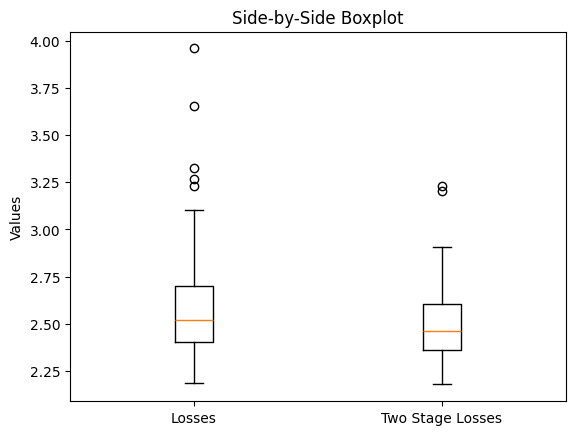

In [59]:
import matplotlib.pyplot as plt

data = [losses, two_stage_losses]
plt.boxplot(data, labels=['Losses', 'Two Stage Losses'])
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
plt.show()